In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import accuracy_score, mean_squared_error, f1_score
from datetime import datetime
from datetime import timedelta
from magi_module import get_report
from xgboost import XGBClassifier

## Data set for ML

In [2]:
macro = pd.read_csv('./data/macro_data.csv', encoding='euc_kr')

/var/folders/tj/56_vjt950tj_fkxdqsptnjkr0000gn/T/ipykernel_6512/4093333955.py:1: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157) have mixed types. Specify dtype option on import or set low_memory=False.
  macro = pd.read_csv('./data/macro_data.csv', encoding='euc_kr')


In [3]:
a = macro.iloc[:1,:].T.iloc[1:,:]
Y_series = a[a[0]=='Y'].T.columns
Q_series = a[a[0]=='Q'].T.columns
M_series = a[a[0]=='M'].T.columns
D_series = a[a[0]=='D'].T.columns
macro = macro.drop(Y_series, axis=1).drop(Q_series, axis=1)
DDR_series = ['DDR4 16G (2G*8) 2666 MHZ(USD)', 'DDR4 16G (2G*8) eTT MHZ(USD)', 'DDR3 4Gb 512Mx8 1600/1866Mbps(USD)', 'DDR3 4Gb 512Mx8 eTT(USD)']
## because the format of ddr_series is differ from others
macro = macro.drop(DDR_series, axis=1)
D_series = D_series.drop(DDR_series)

In [4]:
macro_data = macro.iloc[1:7812,:]
date = pd.to_datetime(macro_data['Item Name'])
macro_data = macro_data.drop('Item Name', axis=1)
macro_data.set_index(date, inplace=True)
macro_data = macro_data.apply(pd.to_numeric)

In [5]:
 #미래참조 경향을 방지하기 위해 lag 취함
macro_lagged = macro_data.copy()
macro_lagged[M_series] = macro_data[M_series].shift(-30)
macro_lagged[D_series] = macro_data[D_series].shift(-1)

In [6]:
start = '2012-01-01'
macro_lagged = macro_lagged.loc[start:,:]
col_macro = macro_lagged.columns
macro_week = macro_lagged.resample('W').mean()
macro_week.describe()
ind_macro = pd.to_datetime(macro_week.index)

RobustScaler로 스케일 맞추기

In [7]:
transformer = RobustScaler().fit(macro_week)
macro_scaled = pd.DataFrame(transformer.transform(macro_week), columns=col_macro, index=ind_macro)

### Label

In [8]:
date_ind = macro_scaled.index
labels = pd.read_csv('./data_label.csv')
labels = labels['012'].iloc[:len(date_ind)]

In [9]:
labels.index = date_ind
labels.value_counts() #0:상승 / 1:횡보 / 2:하락

012
0    206
2    151
1    136
Name: count, dtype: int64

In [10]:
df = pd.merge(macro_week, labels, how='inner', left_index=True, right_index=True)
df.rename(columns={'012':'Position'}, inplace=True)
df

,선행종합지수(2015=100)(2015=100),선행종합지수 전월비(2015=100),재고순환지표(2015=100),경제심리지수(2015=100),수출입물가비율(2015=100)(2015=100),장단기금리차(2015=100),동행종합지수(2015=100)(2015=100),광공업생산지수(2015=100)(2015=100),동행종합지수 전월비(2015=100),동행지수 순환변동치(2015=100),...,납(선물)($/ton),니켈(선물)($/ton),주석(선물)($/ton),아연(선물)($/ton),한국(2015=100),미국(2015=100),일본(2015=100),영국(2015=100),독일(2015=100),Position
Item Name,,,,,,,,,,,,,,,,,,,,,
2012-01-01,86.8,0.2,-13.6,101.4,84.5,0.25,89.6,97.2,-0.1,100.3,...,2003.000000,18255.000000,18925.000000,1845.000000,98.1,95.5,103.9,100.8,97.3,1
2012-01-08,86.8,0.2,-13.6,101.4,84.5,0.25,89.6,97.2,-0.1,100.3,...,2010.142857,18641.428571,19742.142857,1851.071429,98.1,95.5,103.9,100.8,97.3,0
2012-01-15,86.8,0.2,-13.6,101.4,84.5,0.25,89.6,97.2,-0.1,100.3,...,2019.071429,19523.571429,20809.285714,1942.071429,98.1,95.5,103.9,100.8,97.3,0
2012-01-22,86.8,0.2,-13.6,101.4,84.5,0.25,89.6,97.2,-0.1,100.3,...,2148.285714,20011.428571,21875.714286,2020.000000,98.1,95.5,103.9,100.8,97.3,0
2012-01-29,86.8,0.2,-13.6,101.4,84.5,0.25,89.6,97.2,-0.1,100.3,...,2283.714286,21272.142857,23503.571429,2152.785714,98.1,95.5,103.9,100.8,97.3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2201.500000,17990.571429,33295.285714,2967.357143,NaN,NaN,NaN,NaN,NaN,0
2021-05-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2166.357143,17570.000000,32002.857143,2943.642857,NaN,NaN,NaN,NaN,NaN,0
2021-05-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2204.571429,17295.571429,32452.571429,2978.857143,NaN,NaN,NaN,NaN,NaN,0


## Machine Learning (XGBoost)

In [11]:
X_train = df.drop('Position', axis=1).loc['2012-01-01':'2018-12-29':, :]
Y_train = df['Position'].loc['2012-01-01':'2018-12-29']

In [12]:
X_test=df.drop('Position', axis=1).loc['2018-12-30':'2021-05-31',:]
Y_test = df['Position'].loc['2018-12-30':'2021-05-31']

## GridSearchCV (Hyperparameter Tuning)

In [13]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators': [1000, 2000, 3000, 4000, 5000], 
    'learning_rate': [0.1, 0.05, 0.01, 0.001], 
    'max_depth': [7, 8], 
    'random_state': [12]
}

grid_search = GridSearchCV(XGBClassifier(), params, cv=3, n_jobs=-1, scoring='f1_weighted')
grid_search.fit(X_train, Y_train)
print(grid_search.best_score_)
print(grid_search.best_params_)

/opt/homebrew/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


0.2763075925666485
{'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 5000, 'random_state': 12}


In [14]:
params = {
    'n_estimators': [4000, 5000, 6000], 
    'learning_rate': [0.08, 0.1, 0.12], 
    'max_depth': [9, 8, 10], 
    'random_state': [12]
}

grid_search = GridSearchCV(XGBClassifier(), params, cv=5, n_jobs=-1, scoring='f1_weighted')
grid_search.fit(X_train, Y_train)
print(grid_search.best_score_)
print(grid_search.best_params_)

/opt/homebrew/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


0.1961713351917171
{'learning_rate': 0.12, 'max_depth': 9, 'n_estimators': 6000, 'random_state': 12}


In [55]:
xgb_model = XGBClassifier(random_state=12, learning_rate=0.2, n_estimators=6000, max_depth=9, n_jobs=-1) # 학습 진행
xgb_model.fit(X_train, Y_train)
xgb_model_predict = xgb_model.predict(X_test) # 평가 데이터 예측
print("Accuracy: %.2f" % (accuracy_score(Y_test, xgb_model_predict) * 100), "%") # 정확도 % 계산
print('F1-Score: %.2f' % (f1_score(Y_test, xgb_model_predict, average='weighted')))

Accuracy: 42.52 %
F1-Score: 0.44


In [53]:
prediction = pd.DataFrame(xgb_model_predict, index=Y_test.index, columns=['prediction'])
# prediction.loc['2019-09-10':'2020-07-03'] #0:상승, 1:횡보, 2:하락

In [36]:
prediction['prediction'].value_counts()

prediction
0    59
2    36
1    32
Name: count, dtype: int64

In [37]:
predict = prediction.copy().resample('d').first()
predict.loc[pd.to_datetime('2021-05-31')]=predict.loc['2021-05-30']
predict = predict.fillna(method='ffill', limit=6)
predict['prediction'].value_counts()

/var/folders/tj/56_vjt950tj_fkxdqsptnjkr0000gn/T/ipykernel_6512/2756868519.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  predict = predict.fillna(method='ffill', limit=6)


prediction
0.0    413
2.0    252
1.0    219
Name: count, dtype: int64

In [38]:
predict

,prediction
Item Name,
2018-12-30,1.0
2018-12-31,1.0
2019-01-01,1.0
2019-01-02,1.0
2019-01-03,1.0
...,...
2021-05-27,1.0
2021-05-28,1.0
2021-05-29,1.0


In [39]:
upward=predict[predict==0].dropna().index
downward=predict[predict==2].dropna().index
sideway = predict[predict==1].dropna().index

해당 날짜가 0이면 이전 날짜까지의 데이터를 활용해서 듀얼모멘텀 스코어 구하기  
해당 날짜가 1이면 이전 날짜까지의 데이터를 활용해서 괴리율 전략  
해당 날짜가 2이면 이전 날짜까지의 데이터를 활용해서 카나리아전략

## 괴리율 전략

In [40]:
price_deviation = pd.read_csv('./price_deviation.csv', encoding = 'euc_kr')
price_deviation['tdate'] = pd.to_datetime(price_deviation['tdate'])
price_deviation = price_deviation.set_index('tdate').drop('Unnamed: 0', axis=1)

ind = price_deviation.index
col = price_deviation.columns

scale = RobustScaler()
price_deviation_scaled =pd.DataFrame(scale.fit_transform(price_deviation), index=ind, columns=col)
price_deviation_scaled

,A091220,A091230,A098560,A102110,A105010,A114820,A117690,A123310,A123320,A130680,...,A371160,A371450,A371460,A371470,A376410,A377990,A381170,A381180,A387270,A387280
tdate,,,,,,,,,,,,,,,,,,,,,
2006-06-27,0.560976,-0.125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-06-28,0.097561,0.275,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-06-29,-0.048780,0.200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-06-30,0.560976,1.225,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-07-03,0.073171,0.200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-25,0.756098,0.850,0.500,-0.608696,0.886792,0.166667,-1.670732,-0.421053,0.214286,-0.148936,...,-0.555215,-0.423077,-0.105263,-0.159624,0.21875,0.603774,-0.952381,-0.734177,-2.078947,1.00
2021-05-26,0.512195,-0.100,-0.225,-0.521739,0.867925,-0.333333,-1.097561,0.263158,-0.142857,-0.138298,...,-0.144172,-0.025641,0.593567,0.389671,0.37500,0.528302,-0.285714,-0.278481,-0.789474,1.75
2021-05-27,0.097561,-0.150,0.225,-0.434783,0.698113,0.000000,0.012195,1.210526,-0.892857,0.489362,...,-0.061350,0.500000,0.096491,0.300469,-0.50000,1.509434,1.333333,0.506329,0.000000,0.00


## 듀얼모멘텀 전략

In [41]:
etf_data = pd.read_csv('./data/etf_data.csv', encoding = 'euc_kr')
etf_data['tdate'] = pd.to_datetime(etf_data['tdate'])
etf_ohlcv = etf_data.set_index(['tdate', 'etf_code', 'data_name'])['value'].unstack()
etf_close = etf_ohlcv['종가'].unstack()

In [42]:
new = etf_close[datetime(2018,12,31)-timedelta(days=370):datetime(2021,5,31)]
def get_momentum(x): 
    code_ls = new.columns.values.tolist()
    momentum = pd.Series(np.zeros(len(code_ls)).tolist(), index=code_ls)
    try: 
        before2w = new[x.name-timedelta(days=20):x.name-timedelta(days=15)].iloc[-1] 
        before1 = new[x.name-timedelta(days=35):x.name-timedelta(days=30)].iloc[-1] 
        before3 = new[x.name-timedelta(days=95):x.name-timedelta(days=90)].iloc[-1] 
        before6 = new[x.name-timedelta(days=185):x.name-timedelta(days=180)].iloc[-1] 
        momentum = 12 * (x / before2w - 1) + 6 * (x / before1 - 1) + 2 * (x / before3 - 1) + (x / before6 - 1) 
    except: 
        pass
    return momentum

momentum = new.apply(lambda x: get_momentum(x), axis=1)
momentum

,A091220,A091230,A098560,A102110,A105010,A114820,A117690,A123310,A123320,A130680,...,A371160,A371450,A371460,A371470,A376410,A377990,A381170,A381180,A387270,A387280
tdate,,,,,,,,,,,,,,,,,,,,,
2017-12-26,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-12-27,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-12-28,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-25,0.694396,-0.771958,1.495913,-0.133227,0.789836,-0.006821,0.157579,0.021207,-0.084878,1.096701,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-05-26,0.496924,-0.407772,1.532570,-0.108845,0.231173,-0.008348,0.524589,-0.018267,-0.027962,1.242801,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-05-27,0.403427,0.060483,1.762536,0.073329,0.495071,0.018742,0.659711,-0.249393,0.415186,0.931338,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 카나리아 전략

In [43]:
defensive_etf = ["A174350", "A302190", "A237440", "A319640", "A305080"]
inverse_etf = ["A217770", "A252710", "A123310"]
canary_etf = ["A117690", "A245360"]

# 카나리아 둘다 모멘텀이 -1 이하 --> 방어 자산군에 가중치 부여
def DAA(x):
    code_ls = new.columns.values.tolist()
    momentum = pd.Series(np.zeros(len(code_ls)).tolist(), index=code_ls)
    try: 
        before2w = new[x.name-timedelta(days=20):x.name-timedelta(days=15)].iloc[-1] 
        before1 = new[x.name-timedelta(days=35):x.name-timedelta(days=30)].iloc[-1] 
        before3 = new[x.name-timedelta(days=95):x.name-timedelta(days=90)].iloc[-1] 
        before6 = new[x.name-timedelta(days=185):x.name-timedelta(days=180)].iloc[-1] 
        momentum = 12 * (x / before2w - 1) + 6 * (x / before1 - 1) + 2 * (x / before3 - 1) + (x / before6 - 1) 
        
        if momentum["A117690"] < -1 or momentum["A245360"] < -1:
            momentum["A302190"] += 2
            momentum["A237440"] += 2
            momentum["A319640"] += 2
            momentum["A250780"] += 2

    except:
        pass
    return momentum
    
canary = new.apply(lambda x: DAA(x), axis=1)
canary

,A091220,A091230,A098560,A102110,A105010,A114820,A117690,A123310,A123320,A130680,...,A371160,A371450,A371460,A371470,A376410,A377990,A381170,A381180,A387270,A387280
tdate,,,,,,,,,,,,,,,,,,,,,
2017-12-26,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-12-27,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-12-28,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-25,0.694396,-0.771958,1.495913,-0.133227,0.789836,-0.006821,0.157579,0.021207,-0.084878,1.096701,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-05-26,0.496924,-0.407772,1.532570,-0.108845,0.231173,-0.008348,0.524589,-0.018267,-0.027962,1.242801,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-05-27,0.403427,0.060483,1.762536,0.073329,0.495071,0.018742,0.659711,-0.249393,0.415186,0.931338,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 스코어 구하기

In [44]:
score_ind = pd.DatetimeIndex(price_deviation_scaled['2018-12-30':'2021-05-31'].index)
score_col = price_deviation_scaled.columns

In [45]:
score = pd.DataFrame(np.NaN, index=score_ind, columns=score_col)
score

,A091220,A091230,A098560,A102110,A105010,A114820,A117690,A123310,A123320,A130680,...,A371160,A371450,A371460,A371470,A376410,A377990,A381170,A381180,A387270,A387280
tdate,,,,,,,,,,,,,,,,,,,,,
2019-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-05-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-05-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
for date in predict.index:
    if date not in score.index:
        continue
    else:
        if date in upward:  #상승장에는 듀얼모멘텀
            score.loc[date,:] = momentum.loc[date,:]
        elif date in sideway:  #횡보장에는 괴리율전략
            score.loc[date,:] = price_deviation_scaled.loc[date,:]
        elif date in downward:   #하락장에는 카나리아전략
            score.loc[date,:] = canary.loc[date,:]


In [47]:
score

,A091220,A091230,A098560,A102110,A105010,A114820,A117690,A123310,A123320,A130680,...,A371160,A371450,A371460,A371470,A376410,A377990,A381170,A381180,A387270,A387280
tdate,,,,,,,,,,,,,,,,,,,,,
2019-01-02,0.121951,-0.250,0.750,-0.173913,0.273585,0.166667,-0.158537,0.631579,-0.857143,1.425532,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-03,-0.097561,-0.050,-1.075,0.173913,0.037736,-1.000000,0.402439,-0.263158,0.321429,1.989362,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-04,-0.219512,-0.125,0.625,0.043478,-0.103774,0.333333,0.365854,-0.578947,0.250000,-0.287234,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-07,-0.219512,0.750,0.500,-0.173913,0.990566,-0.500000,-0.280488,-0.210526,1.000000,-1.329787,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-08,-0.243902,0.150,-0.125,-0.043478,1.415094,0.166667,0.158537,-0.210526,0.678571,0.053191,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-25,0.756098,0.850,0.500,-0.608696,0.886792,0.166667,-1.670732,-0.421053,0.214286,-0.148936,...,-0.555215,-0.423077,-0.105263,-0.159624,0.21875,0.603774,-0.952381,-0.734177,-2.078947,1.00
2021-05-26,0.512195,-0.100,-0.225,-0.521739,0.867925,-0.333333,-1.097561,0.263158,-0.142857,-0.138298,...,-0.144172,-0.025641,0.593567,0.389671,0.37500,0.528302,-0.285714,-0.278481,-0.789474,1.75
2021-05-27,0.097561,-0.150,0.225,-0.434783,0.698113,0.000000,0.012195,1.210526,-0.892857,0.489362,...,-0.061350,0.500000,0.096491,0.300469,-0.50000,1.509434,1.333333,0.506329,0.000000,0.00


,QUAN_5,QUAN_4,QUAN_3,QUAN_2,QUAN_1,L-S,RANK_L-S
RETURN,0.805794,1.025054,1.354110,1.760673,2.730244,3.006857,2.567627
MDD,-0.467478,-0.358197,-0.337886,-0.261848,-0.120335,-0.333522,-0.258961
TURNOVER,175.855654,271.593043,300.256460,283.751267,178.416775,354.272429,296.206659
CAGR,-0.069447,0.008282,0.106330,0.207516,0.397657,0.443348,0.369338
SHARPE,-0.063757,0.031611,0.180887,0.346643,0.538880,0.383878,0.405703


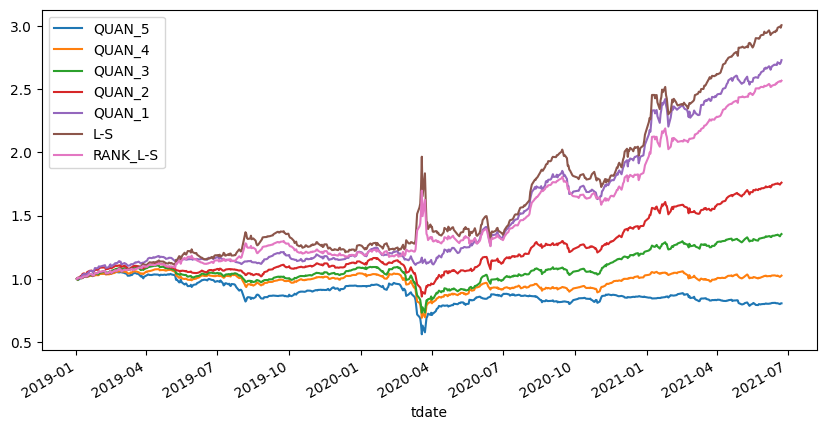

In [48]:
summ, ress = get_report(score)
ress.plot(figsize = (10, 5))
summ

In [49]:
def long_only_sig_to_weight(sig_series, sig, weight):
    long_count = (sig_series == sig).sum()
    
    if (long_count != 0):
        sig_series.loc[(sig_series != sig)] = np.NaN
        sig_series.loc[sig_series == sig] = weight / long_count
    else:
        sig_series.loc[:] = np.NaN
    
    return sig_series.fillna(0.)

def lower_turnover(score, target_start_date, target_end_date, threshold, resampling):
    ## 각 날짜별 quan1부터 quan5까지 나누기
    score= score.loc[target_start_date : target_end_date]
    sig_data = score.rank(1, 'first').apply(lambda x : pd.qcut(x, 5, labels = False,) if not x.isnull().all() else x, 1)
    delete = []

    for signal in range(5):
        name = f'quan_{signal}'  #동일비중 포트폴리오 구성
        weight_sig_data = sig_data.copy().apply(long_only_sig_to_weight, axis=1, args=(signal, 1))
        port = weight_sig_data.fillna(0)

        turnover = weight_sig_data.diff()  # turnover 계산1 --> weight의 변화분 찾는 것. weight가 변했다 = 그 주식을 매매했다 (포트에서 비중이 변동됨)
        turnover.iloc[0] = weight_sig_data.iloc[0]

        #turnover 계산2 --> 특정날짜의 weight 변동값의 절대값을 모든 ETF에 대해 더하고 2로 나눠서 (왜냐하면 더하고 뺀 값 중복을 방지하기 위해) 다시 모든 날짜에 대해 더해서 하나의 scalar값으로 나오게끔함
        TO = (abs(turnover).sum(1) / 2)
        delete_sub= []

        for i in range(len(TO)-1):
            if TO.iloc[i] < threshold: #특정날짜의 weight 변동값의 절대값 합이 작은 경우 해당 날짜를 score에서 제외시킴. (리밸런싱 안 함)
                delete_sub.append(i)
        delete.append(delete_sub)

    c = set(delete[0])
    for i in delete:
        for j in delete:
            if i != j:
                b= set(i).intersection(j)
                c = set(c).union(b)
            else:
                continue

    delete_common = list(c)
    print('delete common is', delete_common)
    
    global score_threshold
    score_threshold = score.drop(score.index[delete_common], axis=0)

    price_deviation_daily_score = score_threshold.resample(resampling).first()
    daily_summary, daily_ress = get_report(price_deviation_daily_score)
    return (daily_summary)


In [50]:
lower_turnover(score, '2018-12-31', '2021-05-31', 0.3, 'D')

delete common is [14, 15, 16, 17, 18, 19, 20, 21, 22, 25, 26, 28, 30, 31, 32, 33, 34, 35, 36, 37, 40, 41, 42, 43, 44, 45, 46, 47, 48, 55, 56, 57, 58, 59, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 74, 75, 76, 77, 78, 80, 82, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 107, 108, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 199, 200, 201, 202, 203, 204, 205, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 231, 232, 233, 234, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 263, 264, 

,QUAN_5,QUAN_4,QUAN_3,QUAN_2,QUAN_1,L-S,RANK_L-S
RETURN,0.977550,1.096473,1.311595,1.514734,1.805977,1.842226,1.691225
MDD,-0.147799,-0.076584,-0.056233,-0.048019,-0.072996,-0.077652,-0.064020
TURNOVER,155.797213,163.357151,167.946497,168.078273,154.169091,309.966304,132.948359
CAGR,-0.007540,0.031176,0.094628,0.148450,0.217785,0.225879,0.191426
SHARPE,-0.020944,0.121572,0.313935,0.443370,0.595013,0.750765,0.756513


In [51]:
submission = score_threshold.stack()

submission = submission.reset_index()
submission.columns = ['tdate', 'code', 'score']
submission.to_csv('./2021_final_score_2024.csv')

,QUAN_5,QUAN_4,QUAN_3,QUAN_2,QUAN_1,L-S,RANK_L-S
RETURN,0.759429,0.992484,1.360524,1.845743,2.888812,3.521211,2.871423
MDD,-0.417647,-0.334644,-0.363711,-0.256775,-0.169528,-0.206942,-0.163981
TURNOVER,121.648728,140.223403,148.404530,144.275111,119.050974,240.699702,204.343174
CAGR,-0.087648,-0.002512,0.108074,0.226659,0.424207,0.521355,0.421344
SHARPE,-0.107257,0.013156,0.179653,0.370422,0.580019,0.508996,0.523947


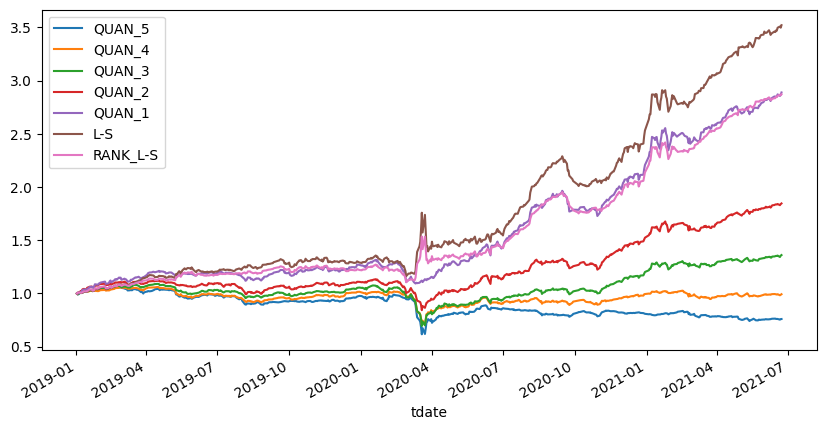

In [52]:
summ, ress = get_report(score_threshold)
ress.plot(figsize = (10, 5))
summ